<a href="https://colab.research.google.com/github/niwatoro/trader-company/blob/main/trader_company_with_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
from tqdm.contrib import tenumerate
import random
from datetime import datetime
from dataclasses import dataclass, field
from numpy.typing import NDArray
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.mixture import GaussianMixture
from IPython.display import display

<Axes: xlabel='Gmt time'>

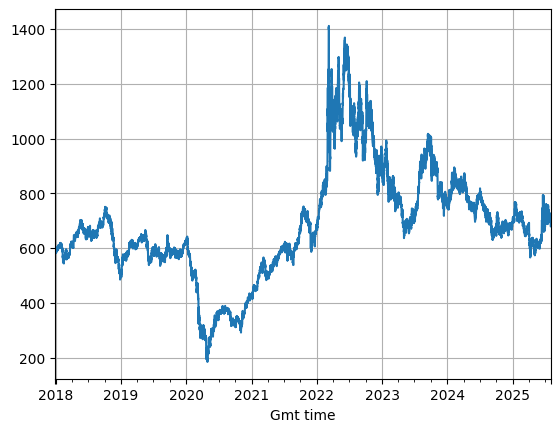

In [ ]:
df_oil = pd.read_csv("drive/MyDrive/DIESEL.CMDUSD_Candlestick_1_Hour_BID_26.12.2017-02.08.2025.csv")
df_oil["Gmt time"] = pd.to_datetime(df_oil["Gmt time"], format="%d.%m.%Y %H:%M:%S.%f")
df_oil["ma_20"] = df_oil["Close"].rolling(20).mean()
df_oil["ma_50"] = df_oil["Close"].rolling(50).mean()
df_oil.set_index("Gmt time", inplace=True)
df_oil["Close"].plot(grid=True)

<Axes: xlabel='Gmt time'>

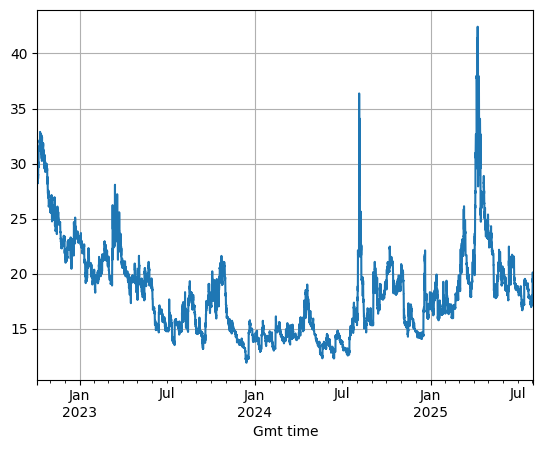

In [ ]:
df_vol = pd.read_csv("drive/MyDrive/VOL.IDXUSD_Candlestick_1_Hour_BID_05.10.2022-02.08.2025.csv")
df_vol["Gmt time"] = pd.to_datetime(df_vol["Gmt time"], format="%d.%m.%Y %H:%M:%S.%f")
df_vol["ma_20"] = df_vol["Close"].rolling(20).mean()
df_vol["ma_50"] = df_vol["Close"].rolling(50).mean()
df_vol.set_index("Gmt time", inplace=True)
df_vol["Close"].plot(grid=True)

<Axes: xlabel='Gmt time'>

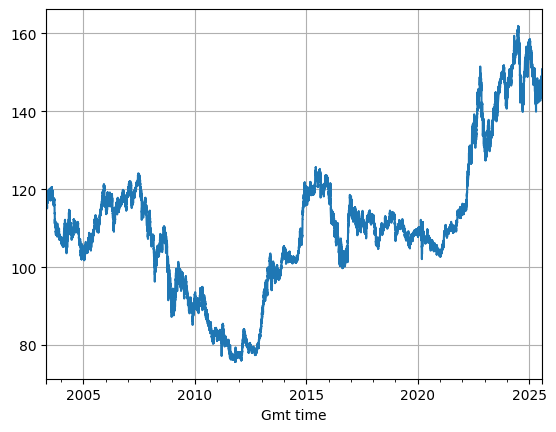

In [ ]:
df_ninja = pd.read_csv("drive/MyDrive/USDJPY_Candlestick_1_Hour_BID_05.05.2003-02.08.2025.csv").iloc[:-30]
df_ninja["Gmt time"] = pd.to_datetime(df_ninja["Gmt time"], format="%d.%m.%Y %H:%M:%S.%f")
df_ninja.set_index("Gmt time", inplace=True)
df_ninja["ma_20"] = df_ninja["Close"].rolling(20).mean()
df_ninja["ma_50"] = df_ninja["Close"].rolling(50).mean()
df_ninja["return"] = np.log(df_ninja["Close"] / df_ninja["Close"].shift(1))
df_ninja["Close"].plot(grid=True)

In [ ]:
df = pd.concat([
    df_ninja["return"],
    df_vol[["Close", "ma_20", "ma_50"]].shift(1),
    df_oil[["Close", "ma_20", "ma_50"]].shift(1),
], axis=1).dropna()
df.columns = ["ret", "vol", "vol_ma_20", "vol_ma_50", "oil", "oil_ma_20", "oil_ma_50", ]
df

,ret,vol,vol_ma_20,vol_ma_50,oil,oil_ma_20,oil_ma_50
Gmt time,,,,,,,
2022-10-07 02:00:00,-0.000510,29.83,29.2505,29.1228,1110.060,1176.95730,1158.68526
2022-10-07 03:00:00,0.000166,29.80,29.3110,29.1316,1109.201,1174.26450,1158.78816
2022-10-07 04:00:00,0.000435,29.89,29.3790,29.1422,1109.978,1170.54245,1158.83352
2022-10-07 05:00:00,-0.000317,29.98,29.4435,29.1546,1112.734,1167.94335,1159.16904
2022-10-07 06:00:00,0.000345,29.94,29.4970,29.1662,1114.234,1165.47190,1159.45434
...,...,...,...,...,...,...,...
2025-08-01 13:00:00,-0.003390,18.97,18.2605,17.7422,703.799,707.17490,709.14848
2025-08-01 14:00:00,-0.000290,19.42,18.3405,17.7772,695.561,706.43875,708.95656
2025-08-01 15:00:00,-0.000216,19.58,18.4380,17.8154,681.302,705.11315,708.34650


In [ ]:
def op_add(x, y): return x + y
def op_sub(x, y): return x - y
def op_mul(x, y): return x * y
def op_x(x, y): return x
def op_y(x, y): return y
def op_max(x, y): return np.maximum(x, y)
def op_min(x, y): return np.minimum(x, y)
def op_gt(x, y): return np.sign(x - y)
def op_lt(x, y): return np.sign(y - x)
def op_corr(x, y):
  if x.size != y.size or x.size < 2:
    return .0
  if not np.isfinite(x).all() or not np.isfinite(y).all():
    return .0
  sx = np.std(x)
  sy = np.std(y)
  if sx == 0 or sy == 0:
    return .0
  return float(np.corrcoef(x, y)[0, 1])

OPERATORS = {
    "add": op_add,
    "sub": op_sub,
    "mul": op_mul,
    "x": op_x,
    "y": op_y,
    "max": op_max,
    "min": op_min,
    "gt": op_gt,
    "lt": op_lt,
    "corr": op_corr,
}

In [ ]:
def act_identity(x): return x
def act_tanh(x): return np.tanh(x)
def act_exp(x): return np.exp(np.clip(x, -10, 10))
def act_sign(x): return np.sign(x)
def act_relu(x): return np.maximum(x, .0)
def act_sinh(x): return np.sinh(x)

ACTIVATIONS = {
    "identity": act_identity,
    "tanh": act_tanh,
    "exp": act_exp,
    "sign": act_sign,
    # "sinh": act_sinh,
    "relu": act_relu,
}

In [ ]:
@dataclass
class Term:
  op: str
  act: str
  var_i: int
  var_j: int
  delay_i: int
  delay_j: int
  weight: float

In [ ]:
@dataclass
class Trader:
  M: int
  terms: list[Term]

  @staticmethod
  def sample_random(
      num_vars: int,
      max_delay: int,
      rng: random.Random,
      M_range: tuple[int, int]=(1, 10),
  ) -> "Trader":
    M = rng.randint(M_range[0], M_range[1])
    terms: list[Term] = []
    for _ in range(M):
      op = rng.choice(list(OPERATORS.keys()))
      act = rng.choice(list(ACTIVATIONS.keys()))
      var_i = rng.randrange(num_vars)
      var_j = rng.randrange(num_vars)
      delay_i = rng.randint(0, max_delay)
      delay_j = rng.randint(0, max_delay)
      weight = rng.uniform(-1., 1.) / math.sqrt(M)
      terms.append(Term(op, act, var_i, var_j, delay_i, delay_j, weight))
    return Trader(M=M, terms=terms)

  @staticmethod
  def fit_weights_l2(
      X: NDArray,
      y: NDArray,
      alpha: float=1e-12,
      sample_weight=None,
  ) -> NDArray:
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    col_std = X.std(axis=0)
    keep = col_std > alpha
    if keep.sum() == 0:
      return np.zeros(X.shape[1], dtype=float)

    model = Ridge(alpha=alpha, fit_intercept=False, copy_X=True, random_state=0)
    model.fit(X[:, keep], y, sample_weight=sample_weight)

    coef = np.zeros(X.shape[1], dtype=float)
    coef[keep] = model.coef_
    return coef

  def _raw_feature_term_value(self, X: NDArray, t: int, term: Term, l: int, w: int) -> float:
    di = term.delay_i
    dj = term.delay_j
    ti = t - l - di
    tj = t - l - dj

    if term.op == "corr":
      if ti - (w - 1) < 0 or tj - (w - 1) < 0:
        return 0.0

      seg_i = X[ti - (w - 1): ti + 1, term.var_i]
      seg_j = X[tj - (w - 1): tj + 1, term.var_j]
      z = op_corr(seg_i, seg_j)
    else:
      if ti < 0 or tj < 0:
        return .0

      x = X[ti, term.var_i]
      y = X[tj, term.var_j]
      z = OPERATORS[term.op](x, y)

    z = ACTIVATIONS[term.act](z)
    return float(z)

  def _features_at_t(self, X: NDArray, t: int, l: int, w: int) -> NDArray:
    return np.asarray([
        float(term.weight * self._raw_feature_term_value(X, t, term, l, w))
        for term in self.terms
    ], dtype=float)

  def predict_at_t(self, X: NDArray, t: int, l: int, w: int) -> float:
    vals = self._features_at_t(X, t, l, w)
    return float(np.nansum(vals))

  def fit_weights_least_squares(
      self,
      X: np.ndarray,
      y: np.ndarray,
      t_index: list[int],
      l: int,
      w: int
  ) -> None:
    Phi: list[list[float]] = []
    yv: list[float] = []

    for t in t_index:
      tv: list[float] = []
      valid: bool = True

      for term in self.terms:
        di = term.delay_i
        dj = term.delay_j
        ti = t - l - di
        tj = t - l - dj

        if term.op == "corr":
          if ti - (w - 1) < 0 or tj - (w - 1) < 0:
            valid = False
            break
        else:
          if ti < 0 or tj < 0:
            valid = False
            break
        tv.append(self._raw_feature_term_value(X, t, term, l, w))

      if valid:
        Phi.append(tv)
        yv.append(y[t + 1])

    if len(Phi) >= self.M:
      Phi = np.asarray(Phi, dtype=float)
      yv = np.asarray(yv, dtype=float)
      coef = self.fit_weights_l2(Phi, yv)
      for k, term in enumerate(self.terms):
        term.weight = float(coef[k])

  @staticmethod
  def _positions_hard_threshold(pred: NDArray, tau: float) -> NDArray:
    pred = np.asarray(pred, dtype=float)
    return np.where(np.abs(pred) > tau, np.sign(pred), .0)

  def cumulative_return(self, X: NDArray, target_returns: NDArray, t_index: list[int], l: int, w: int) -> float:
    pnl = .0
    tau = .75 * np.nanstd(target_returns[t_index])
    for t in t_index:
      pred = self.predict_at_t(X, t, l, w)
      pnl += self._positions_hard_threshold(pred, tau) * target_returns[t + 1]
    return float(pnl)

In [ ]:
pipe = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    RidgeCV(alphas=np.logspace(-4, 2, 20), cv=TimeSeriesSplit(n_splits=5)),
)

@dataclass
class Company:
  target_var: int
  w: int=10
  l: int=1
  num_traders: int=128
  max_delay: int=10
  Q: float=.5
  rng: random.Random=field(default_factory=random.Random)
  traders: list[Trader]=field(default_factory=list)
  aggregator: Pipeline | None=None
  diversity_lambda: float=.2

  def initialize_traders(self, num_vars: int, M_range=(1, 10)) -> None:
    self.traders = [
        Trader.sample_random(
            num_vars=num_vars,
            max_delay=self.max_delay,
            rng=self.rng,
            M_range=M_range
        ) for _ in range(self.num_traders)
    ]

  def predict_one(self, X: NDArray, t: int) -> float:
    feats = np.array([tr.predict_at_t(X, t, self.l, self.w) for tr in self.traders], dtype=float)
    if self.aggregator is None:
      return float(np.nansum(feats))
    return float(self.aggregator.predict(feats.reshape(1, -1))[0])

  def _fit_gmms_from_elite(self, elite: list[Trader]) -> dict:
    delays_i = []
    delays_j = []
    weights = []
    ops = []
    acts = []
    vis = []
    vjs = []
    Ms = []

    for tr in elite:
      Ms.append(tr.M)
      for term in tr.terms:
        delays_i.append(term.delay_i)
        delays_j.append(term.delay_j)
        weights.append(term.weight)
        ops.append(term.op)
        acts.append(term.act)
        vis.append(term.var_i)
        vjs.append(term.var_j)

    params = {}

    def fit_gmm_1d(samples: list, n_components=2) -> GaussianMixture:
      samples = np.asarray(samples, dtype=float).reshape(-1, 1)
      if samples.shape[0] < n_components:
        return None
      if np.std(samples) < 1e-12:
        return None

      try:
        gmm = GaussianMixture(
            n_components=min(n_components, max(1, samples.shape[0])),
            covariance_type="full",
            reg_covar=1e-3,
            random_state=0,
        )
        gmm.fit(samples)
        return gmm
      except Exception as e:
        print(e)
        return None

    params["gmm_delay_i"] = fit_gmm_1d(delays_i)
    params["gmm_delay_j"] = fit_gmm_1d(delays_j)
    params["gmm_weight"] = fit_gmm_1d(weights, n_components=3)

    def freq_dist(values: list) -> tuple[list, list]:
      values = list(values)
      uniq, counts = np.unique(values, return_counts=True)
      probs = counts / counts.sum()
      return list(uniq), list(probs)

    params["ops"] = freq_dist(ops) if ops else (
        list(OPERATORS.keys()), [1 / len(OPERATORS)] * len(OPERATORS)
    )
    params["acts"] = freq_dist(acts) if acts else (
        list(ACTIVATIONS.keys()), [1 / len(ACTIVATIONS)] * len(ACTIVATIONS)
    )
    params["vis"] = freq_dist(vis) if vis else ([0], [1.])
    params["vjs"] = freq_dist(vjs) if vjs else ([0], [1.])
    params["Ms"] = freq_dist(Ms) if Ms else ([3], [1.])
    return params

  def _sample_from_gmm_or_empirical(
      self,
      gmm: GaussianMixture,
      samples: list[int],
      clamp: tuple[int, int]=None,
      is_int: bool=False
  ) -> float | int:
    if gmm is not None:
      val = float(gmm.sample()[0].ravel()[0])
    else:
      if not samples:
        val = .0
      else:
        mu = float(np.mean(samples))
        sigma = float(np.std(samples) if np.std(samples) > 0 else 1.)
        val = float(self.rng.normalvariate(mu, sigma * .25))
    if clamp is not None:
      val = max(clamp[0], min(clamp[1], val))
    if is_int:
      val = int(round(val))
    return val

  def _generate_new_trader_from_gmm(self, num_vars: int, params: dict) -> Trader:
    ops_vals, ops_p = params["ops"]
    acts_vals, acts_p = params["acts"]
    vis_vals, vis_p = params["vis"]
    vjs_vals, vjs_p = params["vjs"]
    Ms_vals, Ms_p = params["Ms"]

    M = int(self.rng.choices(Ms_vals, weights=Ms_p, k=1)[0])
    M = max(1, min(10, M))

    terms: list[Term] = []
    for _ in range(M):
      op = self.rng.choices(ops_vals, weights=ops_p, k=1)[0]
      act = self.rng.choices(acts_vals, weights=acts_p, k=1)[0]
      vi = int(self.rng.choices(vis_vals, weights=vis_p, k=1)[0]) % num_vars
      vj = int(self.rng.choices(vjs_vals, weights=vjs_p, k=1)[0]) % num_vars

      di = self._sample_from_gmm_or_empirical(
          params["gmm_delay_i"],
          [t.delay_i for tr in self.traders for t in tr.terms],
          clamp=None,
          is_int=True,
      )
      dj = self._sample_from_gmm_or_empirical(
          params["gmm_delay_j"],
          [t.delay_j for tr in self.traders for t in tr.terms],
          clamp=None,
          is_int=True,
      )
      w = self._sample_from_gmm_or_empirical(
          params["gmm_weight"],
          [t.weight for tr in self.traders for t in tr.terms],
          clamp=None,
          is_int=False,
      )
      terms.append(Term(op=str(op), act=str(act), var_i=vi, var_j=vj, delay_i=di, delay_j=dj, weight=float(w)))
    return Trader(M=len(terms), terms=terms)

  def _find_bad_traders(
      self,
      X: NDArray,
      target_returns: NDArray,
      t_index: list[int]
  ) -> tuple[list[int], list[int]]:
    scores = np.array([
        tr.cumulative_return(X, target_returns, t_index, self.l, self.w)
        for tr in self.traders
    ], dtype=float)
    thresh = np.percentile(scores, self.Q * 100.)
    bad_idx = [i for i, s in enumerate(scores) if s <= thresh]
    return scores, bad_idx

  def _trader_outputs_matrix(self, X: NDArray, t_index: list[int], standardize: bool=True) -> NDArray:
    Z = np.array([[tr.predict_at_t(X, t, self.l, self.w) for tr in self.traders] for t in t_index], dtype=float)
    if standardize:
      Z = (Z - Z.mean(axis=0, keepdims=True)) / (Z.std(axis=0, keepdims=True) + 1e-9)
    return Z

  def _select_elite_diverse_greedy(
      self,
      X: NDArray,
      t_index: list[int],
      scores: NDArray,
      k: int,
      lam: float
  ) -> NDArray:
    Z = self._trader_outputs_matrix(X, t_index, standardize=True)
    N = Z.shape[1]
    C = (Z.T @ Z) / (Z.shape[0] + 1e-9)
    C = np.clip(C, -1., 1.)
    scores = np.asarray(scores, dtype=float)

    selected = [int(np.nanargmax(scores))]
    remaining = set(range(N)) - set(selected)
    while len(selected) < min(k, N) and remaining:
      sel = np.array(selected, dtype=int)
      maxcorr = np.max(np.abs(C[:, sel]), axis=1)
      cand = np.array(list(remaining), dtype=int)
      adj = scores[cand] - lam * maxcorr[cand]
      nxt = int(cand[np.nanargmax(adj)])
      selected.append(nxt)
      remaining.remove(nxt)
    return np.array(selected[:k], dtype=int)

  def train_epoch(self, X: NDArray, target_returns: NDArray, t_index: list[int]) -> None:
    scores, bad_idx = self._find_bad_traders(X, target_returns, t_index)

    for i in bad_idx:
      self.traders[i].fit_weights_least_squares(X, target_returns, t_index, self.l, self.w)

    scores, bad_idx = self._find_bad_traders(X, target_returns, t_index)

    k = max(1, int(round(self.Q * len(self.traders))))
    elite_idx = self._select_elite_diverse_greedy(X, t_index, scores, k, lam=self.diversity_lambda)
    elite = [self.traders[i] for i in elite_idx]
    params = self._fit_gmms_from_elite(elite)

    new_traders: list[Trader] = [
        self._generate_new_trader_from_gmm(num_vars=X.shape[1], params=params)
        for _ in bad_idx
    ]

    for idx, nt in zip(bad_idx, new_traders):
      self.traders[idx] = nt

  def fit_aggregator(self, X: NDArray, target_returns: NDArray, t_index: list[int]) -> None:
    Z = np.array([[tr.predict_at_t(X, t, self.l, self.w) for tr in self.traders] for t in t_index], dtype=float)
    y = np.array([target_returns[t + 1] for t in t_index], dtype=float)
    self.aggregator = pipe.fit(Z, y)

  def accuracy(self, preds: NDArray, actual: NDArray) -> float:
    return float((np.sign(preds) == np.sign(actual)).mean())

  def canonical_trade_returns(self, preds: NDArray, actual: NDArray) -> NDArray:
    simple = np.expm1(actual)
    return np.sign(preds) * simple

  def evaluate(self, preds: NDArray, actual: NDArray) -> dict[str, float]:
    trade_rets = self.canonical_trade_returns(preds, actual)
    cum = np.cumprod(1. + trade_rets)
    AR = (cum[-1] ** (24 * 365 / len(cum))) - 1.
    SR = np.mean(trade_rets) / (np.std(trade_rets) + 1e-9) * np.sqrt(24 * 365)
    roll_max = np.maximum.accumulate(cum)
    dd = (cum / roll_max) - 1.
    CR = (np.mean(trade_rets) * 24 * 365) / (1e-9 + np.abs(np.min(dd)))
    return {
        "ACC": self.accuracy(preds, actual),
        "AR_%": 100. * AR,
        "SR": SR,
        "CR": CR,
        "cum_end": cum[-1],
    }

In [ ]:
def plot_equity_curve(time_series: NDArray, trade_rets: NDArray) -> None:
  cum = np.cumprod(1. + trade_rets)

  plt.plot(time_series, cum)
  plt.xticks(rotation=90)
  plt.grid()
  plt.show()

def plot_aggregator_coeffs(company: Company, top_k: int=20, title: str="Aggregator Coefficients") -> None:
  coefs = getattr(company.aggregator.steps[-1][1], "coef_", None)
  idx = np.argsort(np.abs(coefs))[-top_k:][::-1]
  x = np.arange(len(idx))
  labels = [str(i) for i in idx]
  y = coefs[idx]

  plt.bar(x, y)
  plt.xticks(x, labels)
  plt.title(title)
  plt.show()

def describe_top_traders(company: Company, top_k: int=5, var_names: list[str] | None=None):
  coefs = getattr(company.aggregator.steps[-1][1], "coef_", None)
  coefs = np.asarray(coefs, dtype=float)

  order = np.argsort(np.abs(coefs))[::-1]
  top_idx = order[:min(top_k, len(coefs))]

  rows = []
  for rank, i in enumerate(top_idx, 1):
    tr = company.traders[i]
    coef = float(coefs[i])
    for m, term in enumerate(tr.terms, 1):
      vi = var_names[term.var_i] if (
          var_names is not None and 0 <= term.var_i < len(var_names)
      ) else str(term.var_i)
      vj = var_names[term.var_j] if (
          var_names is not None and 0 <= term.var_j < len(var_names)
      ) else str(term.var_j)

      rows.append({
        "rank": rank,
        "trader_idx": i,
        "agg_coef": coef,
        "M": tr.M,
        "term_no": m,
        "term_weight": term.weight,
        "op": term.op,
        "act": term.act,
        "var_i": term.var_i,
        "var_j": term.var_j,
        "var_i_name": vi if isinstance(vi, str) else str(vi),
        "var_j_name": vj if isinstance(vj, str) else str(vj),
        "delay_i": term.delay_i,
        "delay_j": term.delay_j,
      })

  display(pd.DataFrame(rows))

In [ ]:
def train_and_eval(df: pd.DataFrame, test_fraction: float=0.1, train_epoch: int=1) -> None:
  rng = random.Random(123)

  X = df.values.astype(float)
  y = df["ret"].values.astype(float)

  T = X.shape[0]
  w = 10
  l = 1
  max_delay = 24
  safe_start = w + l + max_delay
  t_all = list(range(safe_start, T - 1))

  split = int(len(t_all) * (1. - test_fraction))
  train_t = t_all[:split]
  test_t = t_all[split:]

  print(f"[{datetime.now().strftime('%Y%m%d %H:%M:%S')}] Initializing...")
  company = Company(target_var=0, num_traders=32, w=w, l=l, max_delay=max_delay, Q=.5, rng=rng)
  company.initialize_traders(num_vars=X.shape[1], M_range=(1, 3))

  print(f"[{datetime.now().strftime('%Y%m%d %H:%M:%S')}] Training...")
  for _ in tqdm(range(train_epoch)):
    company.train_epoch(X, y, train_t)

  print(f"[{datetime.now().strftime('%Y%m%d %H:%M:%S')}] Fitting aggregator...")
  company.fit_aggregator(X, y, train_t)

  print(f"[{datetime.now().strftime('%Y%m%d %H:%M:%S')}] Evaluating...")
  train_preds = np.array([company.predict_one(X, t) for t in train_t])
  test_preds = np.array([company.predict_one(X, t) for t in test_t])
  train_actual = np.array([y[t + 1] for t in train_t])
  test_actual = np.array([y[t + 1] for t in test_t])

  train_tr = company.canonical_trade_returns(train_preds, train_actual)
  test_tr = company.canonical_trade_returns(test_preds, test_actual)

  print(f"[{datetime.now().strftime('%Y%m%d %H:%M:%S')}] Displaying results...")
  plot_equity_curve(df.index[train_t], train_tr)
  plot_equity_curve(df.index[test_t], test_tr)
  plot_aggregator_coeffs(company)
  describe_top_traders(company, 5, df.columns)

  train_metrics = company.evaluate(train_preds, train_actual)
  test_metrics = company.evaluate(test_preds, test_actual)

  print("[Train]")
  for key, val in train_metrics.items():
    print(f"{key}:\t{val:.3f}")
  print()
  print("[Test]")
  for key, val in test_metrics.items():
    print(f"{key}:\t{val:.3f}")

[20250810 12:15:04] Initializing...
[20250810 12:15:04] Training...


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.37151e-22): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
100%|██████████| 1/1 [03:29<00:00, 209.04s/it]


[20250810 12:18:33] Fitting aggregator...
[20250810 12:20:08] Evaluating...
[20250810 12:22:18] Displaying results...


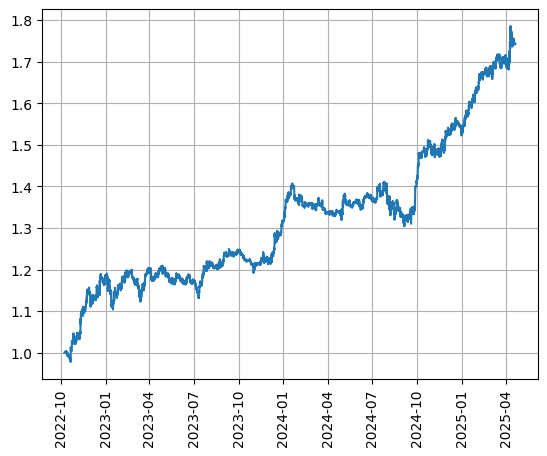

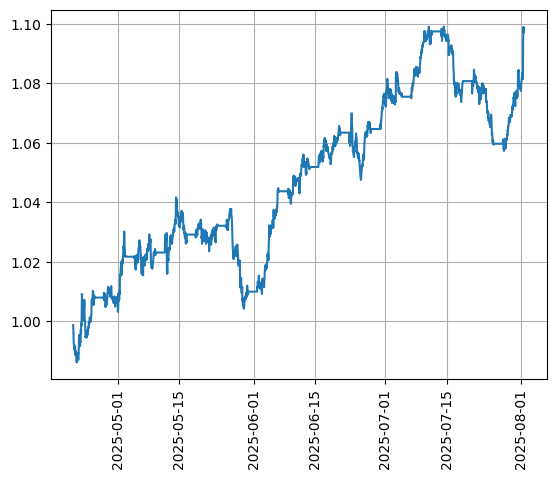

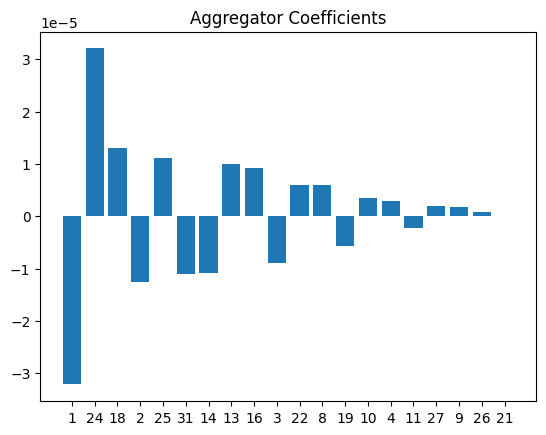

,rank,trader_idx,agg_coef,M,term_no,term_weight,op,act,var_i,var_j,var_i_name,var_j_name,delay_i,delay_j
0,1,1,-0.000032,2,1,4.964656e-02,x,exp,4,5,oil,oil_ma_20,22,7
1,1,1,-0.000032,2,2,4.964656e-02,sub,identity,2,2,vol_ma_20,vol_ma_20,22,7
2,2,24,0.000032,3,1,-7.861902e-08,y,relu,0,2,ret,vol_ma_20,23,12
3,2,24,0.000032,3,2,-9.749480e-08,sub,exp,2,1,vol_ma_20,vol,13,11
4,2,24,0.000032,3,3,6.854863e-06,corr,identity,3,5,vol_ma_50,oil_ma_20,5,6
5,3,18,0.000013,3,1,2.208592e-01,corr,sign,2,5,vol_ma_20,oil_ma_20,18,3
6,3,18,0.000013,3,2,-1.631932e-01,max,sign,2,5,vol_ma_20,oil_ma_20,13,10
7,3,18,0.000013,3,3,-1.358222e-01,gt,exp,6,6,oil_ma_50,oil_ma_50,6,5
8,4,2,-0.000013,3,1,4.964656e-02,corr,tanh,0,5,ret,oil_ma_20,22,7
9,4,2,-0.000013,3,2,4.964656e-02,gt,exp,0,2,ret,vol_ma_20,22,7


[Train]
ACC:	0.357
AR_%:	24.473
SR:	2.046
CR:	2.974
cum_end:	1.742

[Test]
ACC:	0.372
AR_%:	39.104
SR:	3.249
CR:	8.804
cum_end:	1.097


In [ ]:
train_and_eval(df)

In [ ]:
def walk_forward_eval(
    df: pd.DataFrame,
    *,
    initial_train_size: int=24*90,
    retrain_every: int=24*7,
    lookback: int | None=None,
    epochs_per_update: int=1,
    num_traders: int=32,
    M_range: tuple[int, int]=(1, 3),
    Q: float=.5,
    seed: int=123,
    min_fit_samples: int=60,
    reset_on_update: bool=False,
) -> dict[str, float]:
  rng = random.Random(seed)

  X = df.values.astype(float)
  y = df["ret"].values.astype(float)

  w = 10
  l = 1
  max_delay = 24
  safe_start =  w + l + max_delay
  T = X.shape[0]

  first_t = safe_start + max(1, int(initial_train_size))

  company = None

  preds: list[float] = []
  actual: list[float] = []
  times: list[pd.Timestamp] = []

  def make_train_index(t_now: int) -> list[int]:
    if lookback is None:
      start = safe_start
    else:
      start = max(safe_start, t_now - int(lookback))
    return list(range(start, t_now))

  steps = list(range(first_t, T - 1))
  last_update_step = -1e9

  for step_idx, t in tenumerate(steps):
    if (company is None) or (t - last_update_step >= retrain_every):
      train_t = make_train_index(t)

      if company is None or reset_on_update:
        company = Company(
            target_var=0,
            num_traders=num_traders,
            w=w,
            l=l,
            max_delay=max_delay,
            Q=Q,
            rng=rng
        )
        company.initialize_traders(num_vars=X.shape[1], M_range=M_range)

      for _ in range(max(1, int(epochs_per_update))):
        company.train_epoch(X, y, train_t)

      if len(train_t) >= int(min_fit_samples):
        company.fit_aggregator(X, y, train_t)
      else:
        company.aggregator = None

      last_update_step = t

    pred = company.predict_one(X, t)
    preds.append(pred)
    actual.append(y[t + 1])
    times.append(df.index[t])

  preds = np.asarray(preds, dtype=float)
  actual = np.asarray(actual, dtype=float)

  trade_rets = company.canonical_trade_returns(preds, actual)
  plot_equity_curve(np.array(times), trade_rets)

  metrics = company.evaluate(preds, actual)
  print("[Walk-forward Test]")
  for k, v in metrics.items():
    print(f"{k}:\t{v:.3f}")

  if company.aggregator is not None:
    plot_aggregator_coeffs(company, top_k=20, title="Aggregator Coefficients (Final)")
    describe_top_traders(company, top_k=5, var_names=df.columns.tolist())

In [ ]:
walk_forward_eval(
    df,
    initial_train_size=24*90,
    retrain_every=24*7*4,
    lookback=None,
    epochs_per_update=1,
    num_traders=32,
    M_range=(1, 3),
    Q=.5,
    min_fit_samples=60,
    reset_on_update=False,
)

  0%|          | 0/22516 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
